In [4]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

questions = pd.read_csv('/Users/eamonyin/Downloads/迪哥nlp/练习/socialmedia_relevant_cols_clean.csv')
questions.columns=['text','choose_one','class_label']
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [5]:
questions.describe()

,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [6]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@' \\\/\"\_\n]", "")
    df[text_field] = df[text_field].str.replace(r"@", " at ")
    df[text_field] = df[text_field].str.lower()
    return df


questions = standardize_text(questions, "text")
questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [9]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10871,10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,10872,police investigating after an e bike collided ...,Relevant,1
10873,10873,the latest more homes razed by northern calif...,Relevant,1
10874,10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,10875,cityofcalgary has activated its municipal eme...,Relevant,1


In [12]:
clean_questions.groupby('class_label').count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6187,6187,6187
1,4673,4673,4673
2,16,16,16


In [13]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions['tokens'] = clean_questions['text'].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [14]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#单词数
all_words = [word for tokens in clean_questions['tokens'] for word in tokens]
#每个句子单词数
sentence_lengths = [len(token) for token in clean_questions['tokens']]
#不重复的词数
VOCAB = sorted(list(set(all_words)))
print("%s words total,with a vocabulary of: %s" % (len(all_words),len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154724 words total,with a vocabulary of: 18101
Max sentence length is 34


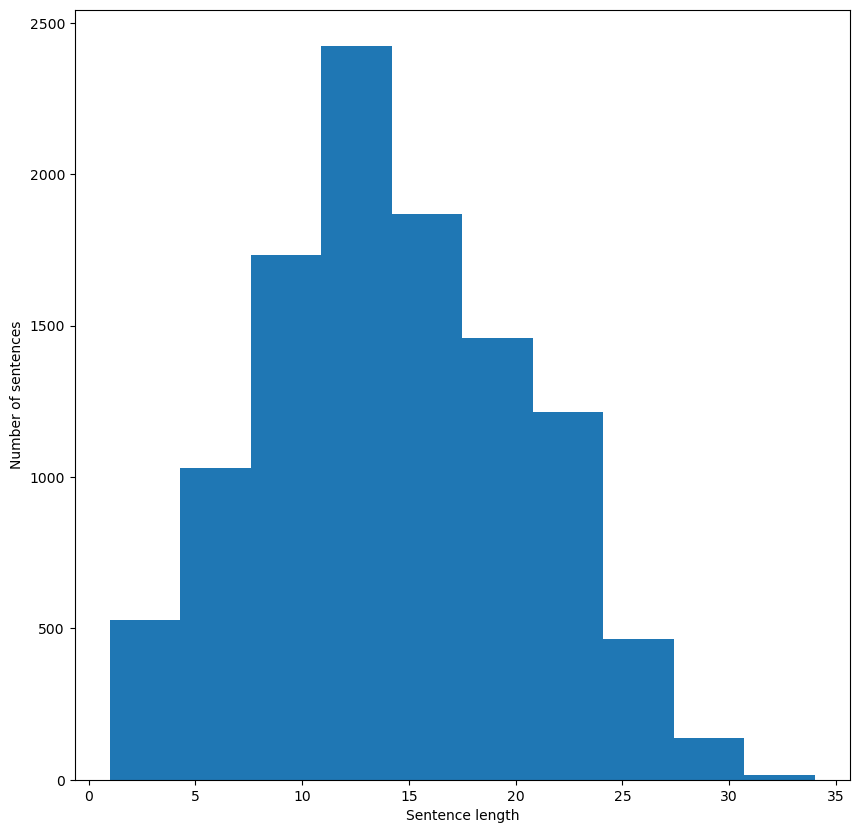

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# 将输入的文本数据进行计数向量化处理
def cv(data):
    # 将文本数据转换为计数向量
    count_vectorizer = CountVectorizer()
    # 使用 CountVectorizer 对象的 fit_transform 方法对输入的数据进行拟合和转换，将文本转换为计数向量矩阵
    # 其中，fit 会学习数据中的词汇表，transform 会将数据转换为矩阵表示
    emb = count_vectorizer.fit_transform(data)
    # 返回转换后的计数向量矩阵和 CountVectorizer 对象
    return emb, count_vectorizer

# 将 clean_questions 的 'text' 列转换为列表，存储在 list_corpus 中
list_corpus = clean_questions["text"].tolist()
# 将 clean_questions 的 'class_label' 列转换为列表，存储在 list_labels 中
list_labels = clean_questions["class_label"].tolist()


# 使用 train_test_split 函数将数据划分为训练集和测试集
# list_corpus 为输入特征，list_labels 为标签
# test_size=0.2 表示测试集占总数据集的 20%
# random_state=40 确保每次运行代码时数据的划分结果一致
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

# 调用 cv 函数对训练集进行计数向量化处理，得到训练集的计数向量矩阵和 CountVectorizer 对象
X_train_counts, count_vectorizer = cv(X_train)

# 使用训练集训练得到的 CountVectorizer 对象对测试集进行转换，得到测试集的计数向量矩阵
X_test_counts = count_vectorizer.transform(X_test)

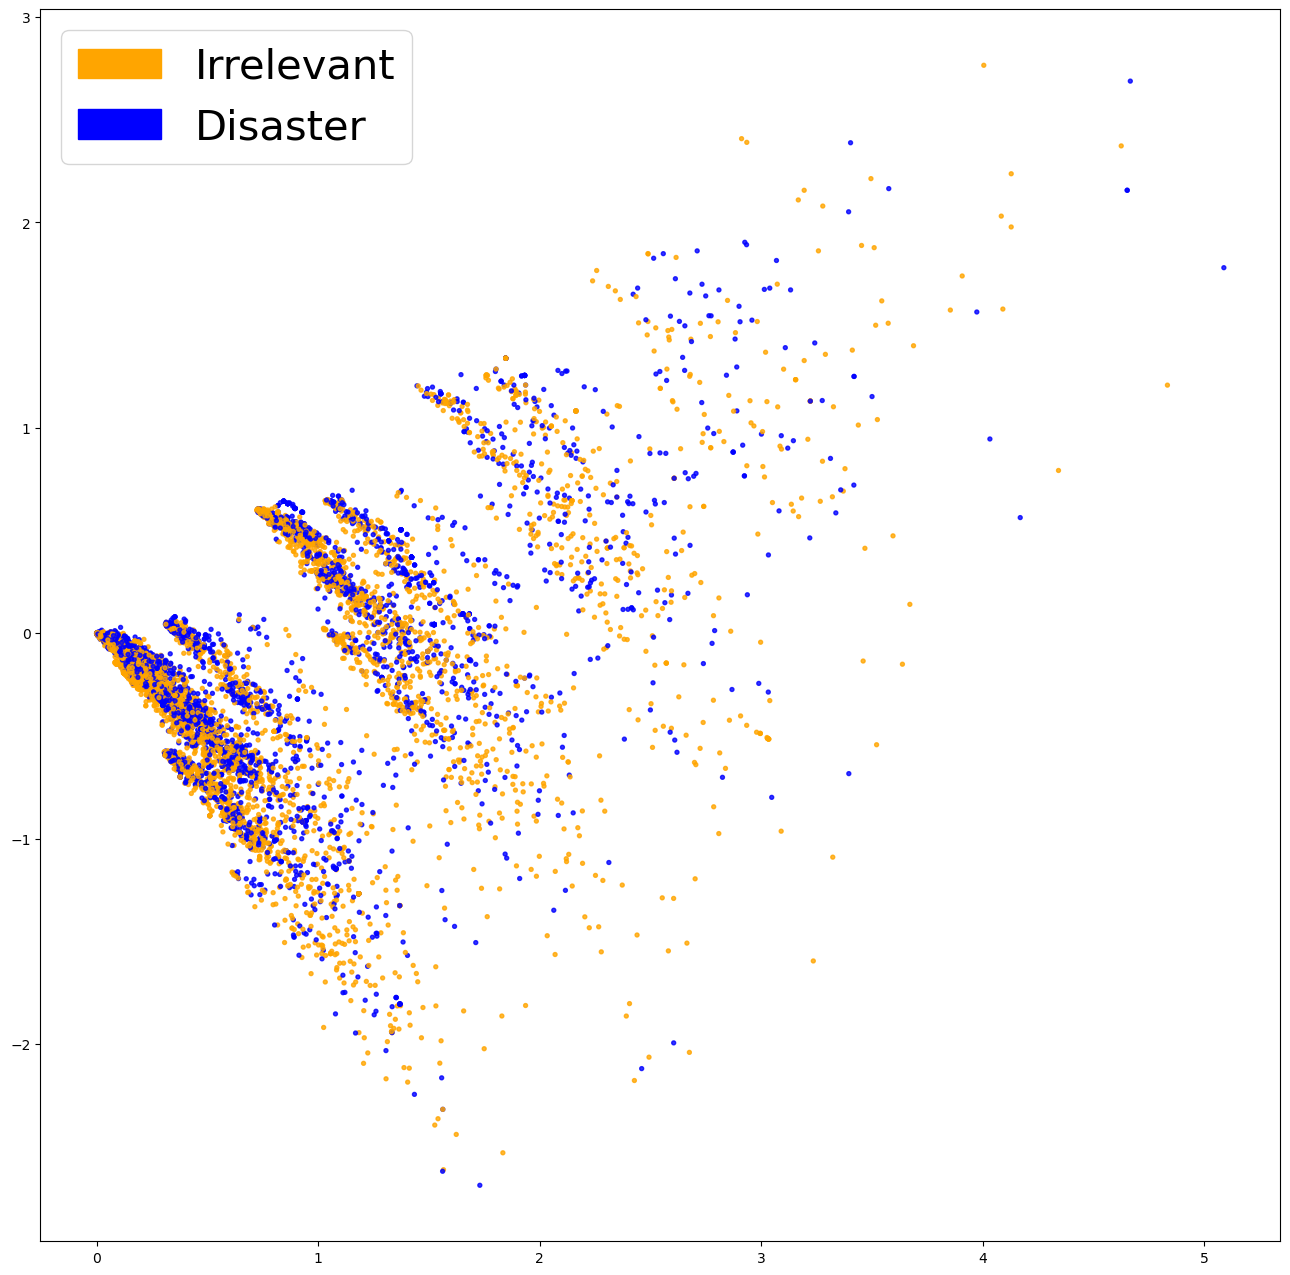

In [19]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange', 'blue', 'blue']
    if plot:
        import matplotlib.pyplot as plt
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')
        green_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40)
# 训练模型
clf.fit(X_train_counts, y_train)
# 使用训练好的逻辑回归模型clf对测试数据X_test_counts进行预测，得到预测结果y_predicted_counts。
y_predicted_counts = clf.predict(X_test_counts)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
# 计算模型评估指标
def get_metrics(y_test, y_predicted):
    # 精确率（预测为正类的样本中，真正是正类的比例）
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')
    # 召回率（真正是正类的样本中，被正确预测为正类的比例）
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    # F1分数（精确率和召回率的调和平均值，能综合反映模型预测的好坏）
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    # 准确率（预测正确的样本数占总样本数的比例）
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

# 计算评估指标，传入 测试集的真实标签 和 预测标签
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
# 格式化输出评估指标，保留三位小数
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.759, recall = 0.761, f1 = 0.760


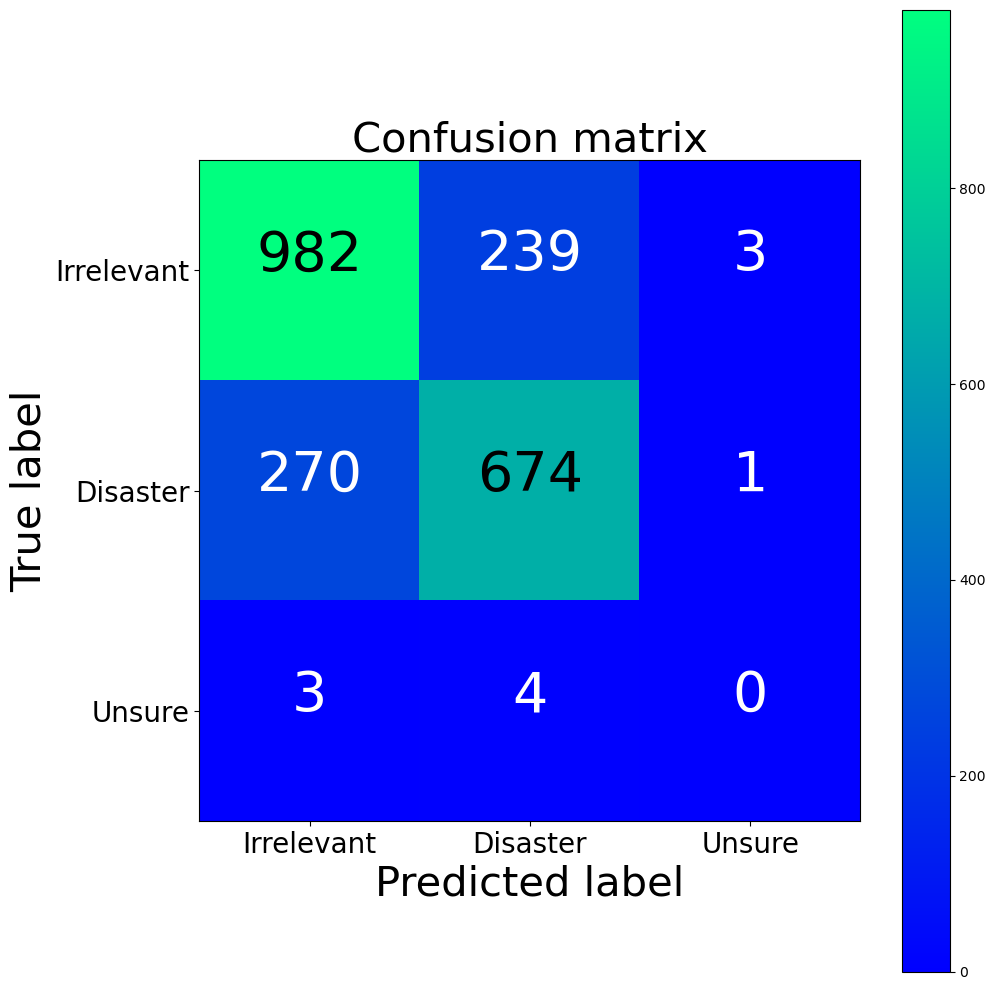

[[982 239   3]
 [270 674   1]
 [  3   4   0]]


In [24]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black",
                 fontsize=40)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant', 'Disaster', 'Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [25]:
def get_most_important_features(vectorizer, model, n=5):
    # 将特征索引映射到特征名称
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}
    # 创建一个空字典，用于存储每个类别的特征重要性
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        # 创建一个列表，包含每个特征的权重和特征名称。
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        # 根据特征权重对特征进行排序，按降序排列。
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        # 获取最重要的 n 个特征。
        tops = sorted_coeff[:n]
        # 获取最不重要的 n 个特征。
        bottom = sorted_coeff[-n:]
        # 将每个类别的最重要和最不重要特征存储在 classes 字典中。
        classes[class_index] = {
            'tops': tops,
            'bottom': bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

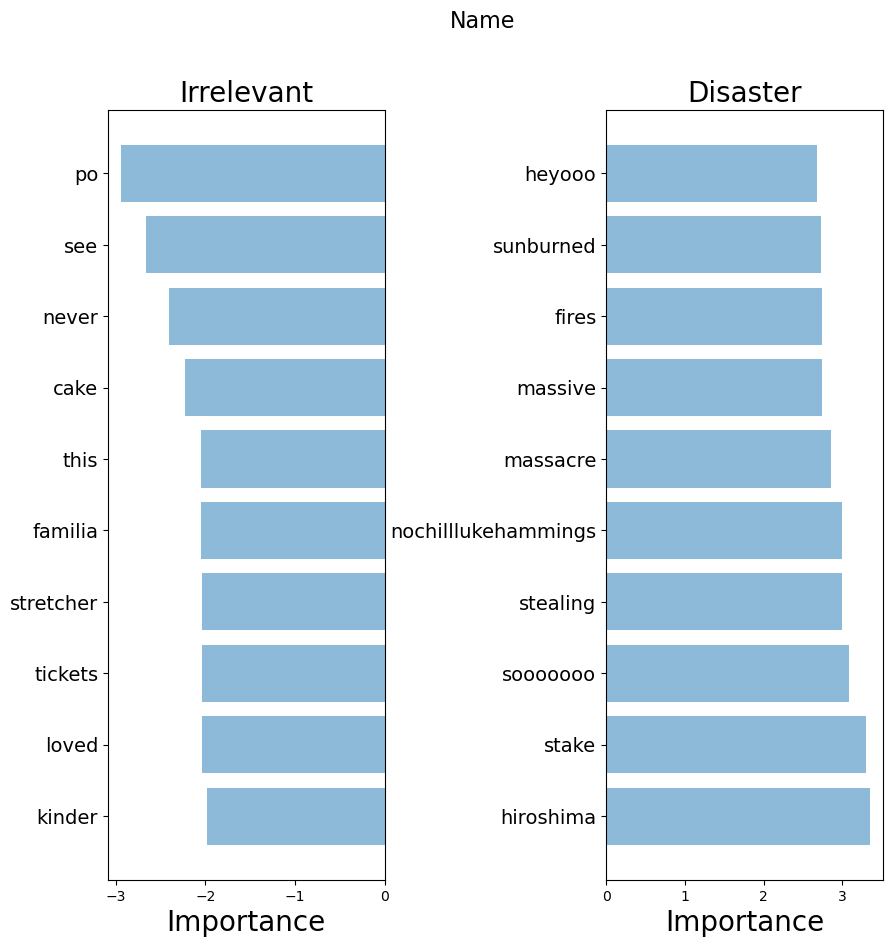

In [29]:
import numpy as np
import matplotlib.pyplot as plt


def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1], reverse=True)
    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.barh(y_pos, bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    plt.subplot(122)
    plt.barh(y_pos, top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle('Name', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")    

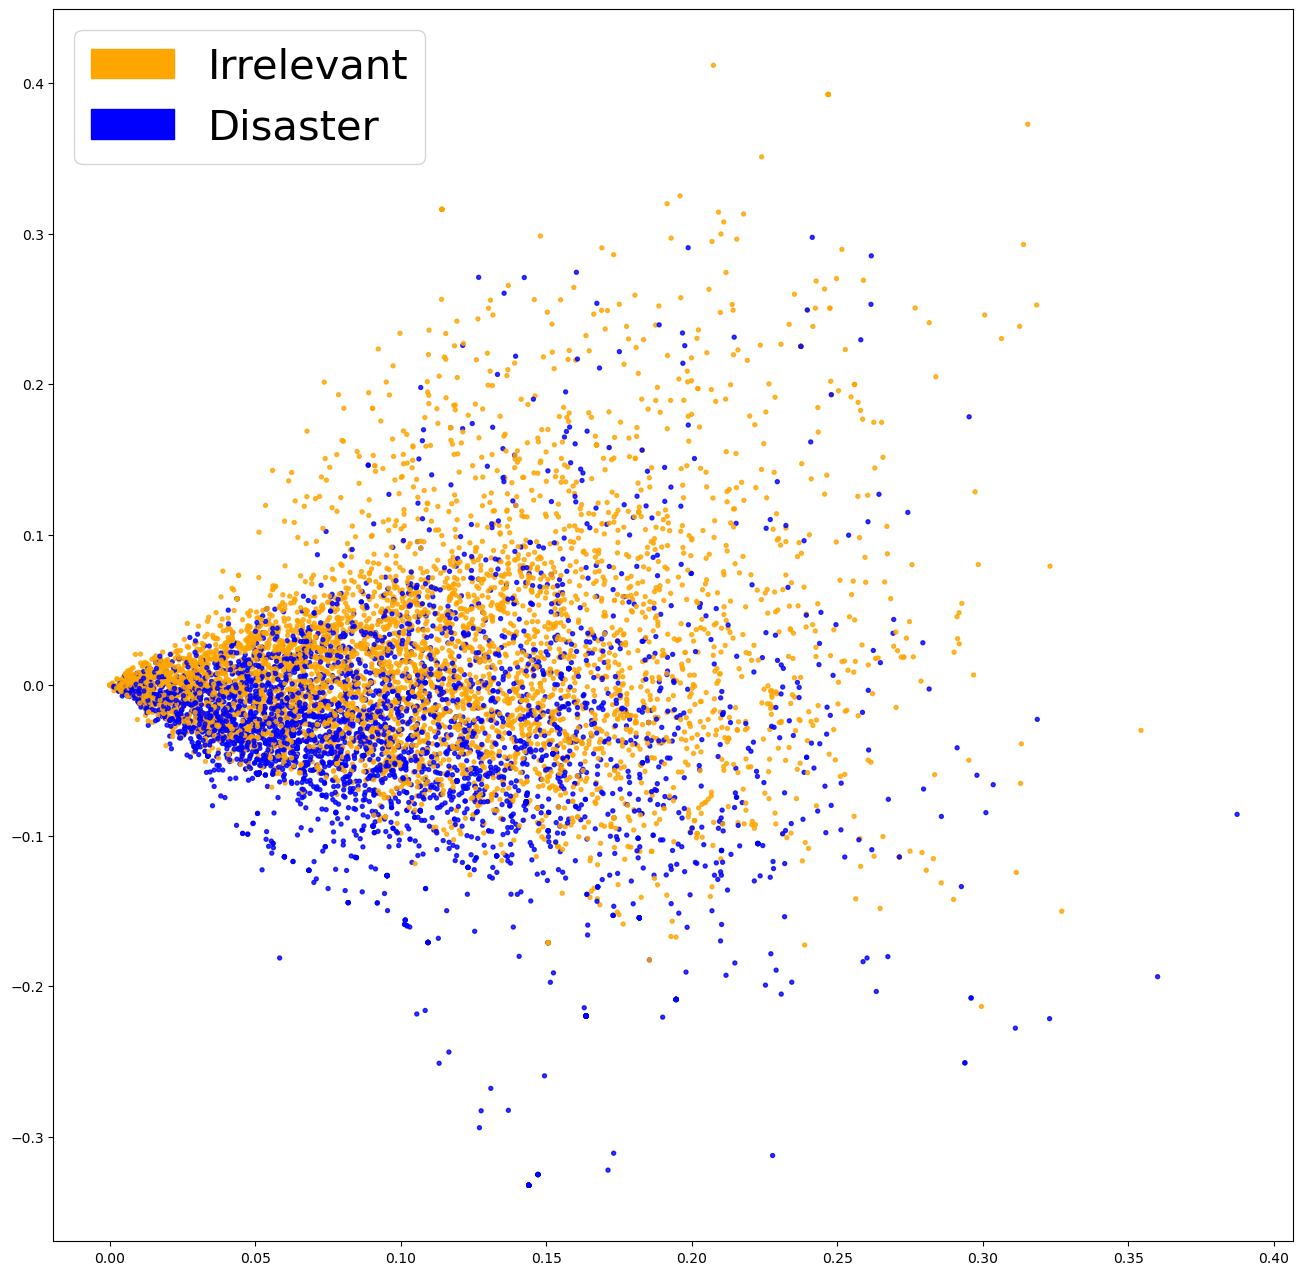

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
# 对输入数据进行 TF-IDF（词频-逆文档频率）转换。
def tfidf(data):
    # 创建一个TfidfVectorizer对象，用于将文本数据转换为 TF - IDF 特征向量。
    tfidf_vectorizer = TfidfVectorizer()
    # 使用fit_transform方法对输入数据进行拟合和转换。fit部分会学习数据中的词汇表，transform部分会将数据转换为 TF-IDF 特征向量
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

# 调用tfidf函数对训练数据X_train进行 TF - IDF 转换，得到转换后的训练数据X_train_tfidf和TfidfVectorizer对象
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
# 使用之前得到的TfidfVectorizer对象对测试数据X_test进行转换，得到转换后的测试数据X_test_tfidf。
X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [31]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40)
# 训练模型
clf_tfidf.fit(X_train_tfidf, y_train)
# 使用训练好的逻辑回归模型clf对测试数据X_test_counts进行预测，得到预测结果y_predicted_counts。
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [32]:
# 计算评估指标，传入 测试集的真实标签 和 预测标签
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
# 格式化输出评估指标，保留三位小数
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

accuracy = 0.762, precision = 0.760, recall = 0.762, f1 = 0.761


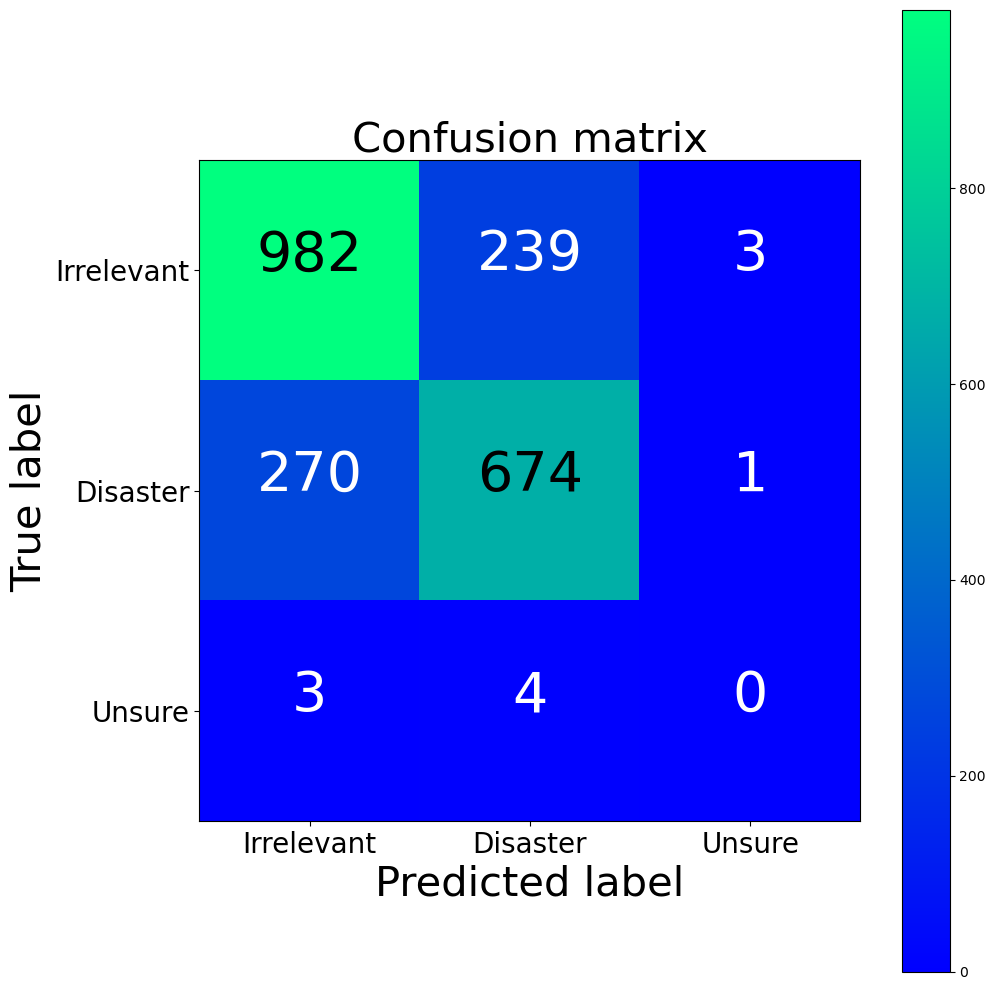

TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
词袋 confusion matrix
[[982 239   3]
 [270 674   1]
 [  3   4   0]]


In [33]:
cm_tfidf = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant', 'Disaster', 'Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm_tfidf)
print("词袋 confusion matrix")
print(cm)

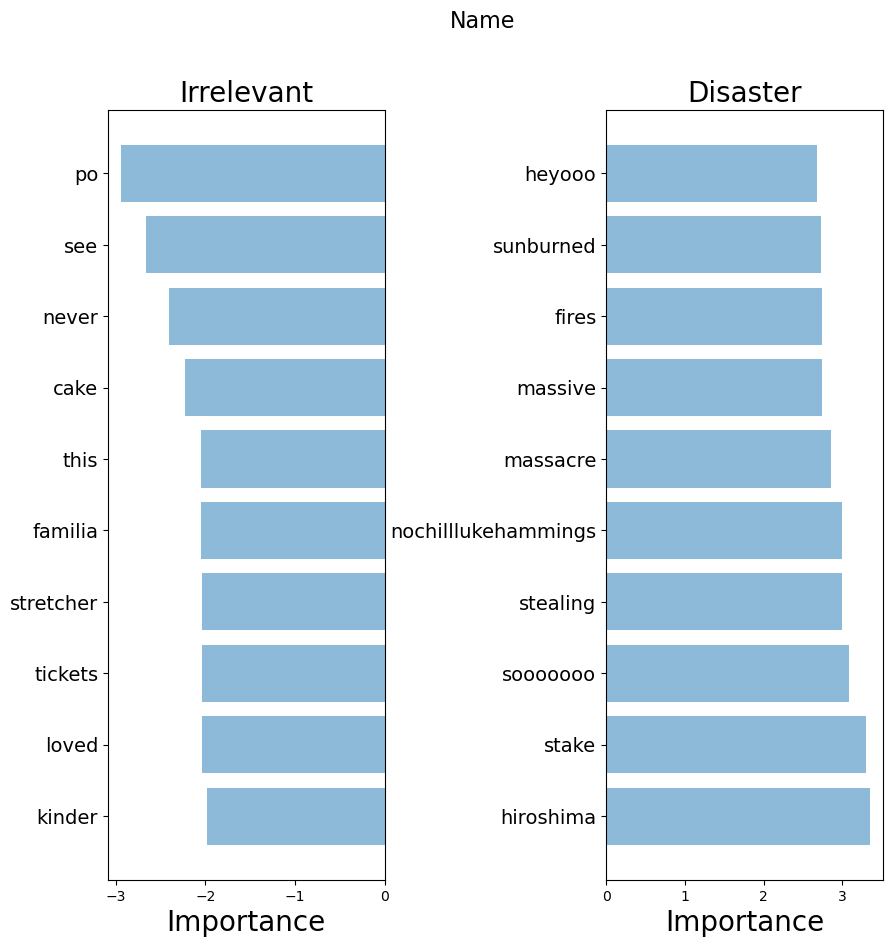

In [35]:
importance = get_most_important_features(count_vectorizer, clf, 10)

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")    

In [42]:
import gensim
import numpy as np
#导入词向量模型
# https://blog.csdn.net/m0_54882482/article/details/129281840
word2vec_path = "/Users/eamonyin/Downloads/迪哥nlp/练习/Gemsim练习/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# 转换词向量讲解：https://www.bilibili.com/video/BV1bSHseAELw?t=166.0&p=71
# 计算给定单词列表的平均词向量（句子向量 = 每个词向量取平均）
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    # 如果generate_missing为True，则对于不在词向量字典中的单词，生成随机向量。
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    # 如果generate_missing为False，则对于不在词向量字典中的单词，使用全零向量。    
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged
# 求每个句子的平均向量
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [43]:
# word2vec:导入的GoogleNews-vectors-negative300.bin模型
# clean_questions：第一节清理过的语料
# 获取word2vec所需的向量化入参
embeddings = get_word2vec_embeddings(word2vec,clean_questions)
# 使用 train_test_split 函数将数据划分为训练集和测试集
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, test_size=0.2, random_state=40)

In [44]:
X_train_word2vec[0]

array([ 0.05639939,  0.02053833,  0.07635207,  0.06914993, -0.01007262,
       -0.04978943,  0.02546038, -0.06045968,  0.04264323,  0.02419935,
        0.00375076, -0.15124639,  0.02915809, -0.01554943, -0.10182699,
        0.05523972,  0.00953747,  0.0834525 ,  0.00200544, -0.0238909 ,
       -0.01706369,  0.09193638,  0.03979783,  0.04899052,  0.04707618,
       -0.09235491, -0.10698809,  0.07503255,  0.04905628, -0.01991781,
        0.04036749, -0.0117856 , -0.00576346,  0.01624843, -0.01823952,
       -0.01545715,  0.06020392,  0.02975609,  0.02211217,  0.07844525,
        0.05023847, -0.09430913,  0.20582217, -0.05274091,  0.00881231,
        0.04394059, -0.01748512, -0.0403268 ,  0.03178769,  0.06038993,
        0.03867458,  0.00492932,  0.05121649,  0.01256743, -0.02096994,
        0.02814593, -0.06389218,  0.01661319, -0.02686709, -0.07981364,
       -0.00288318,  0.07032367, -0.07524182, -0.01155599, -0.0259661 ,
        0.00625901, -0.05474758, -0.00059877, -0.01737177,  0.07

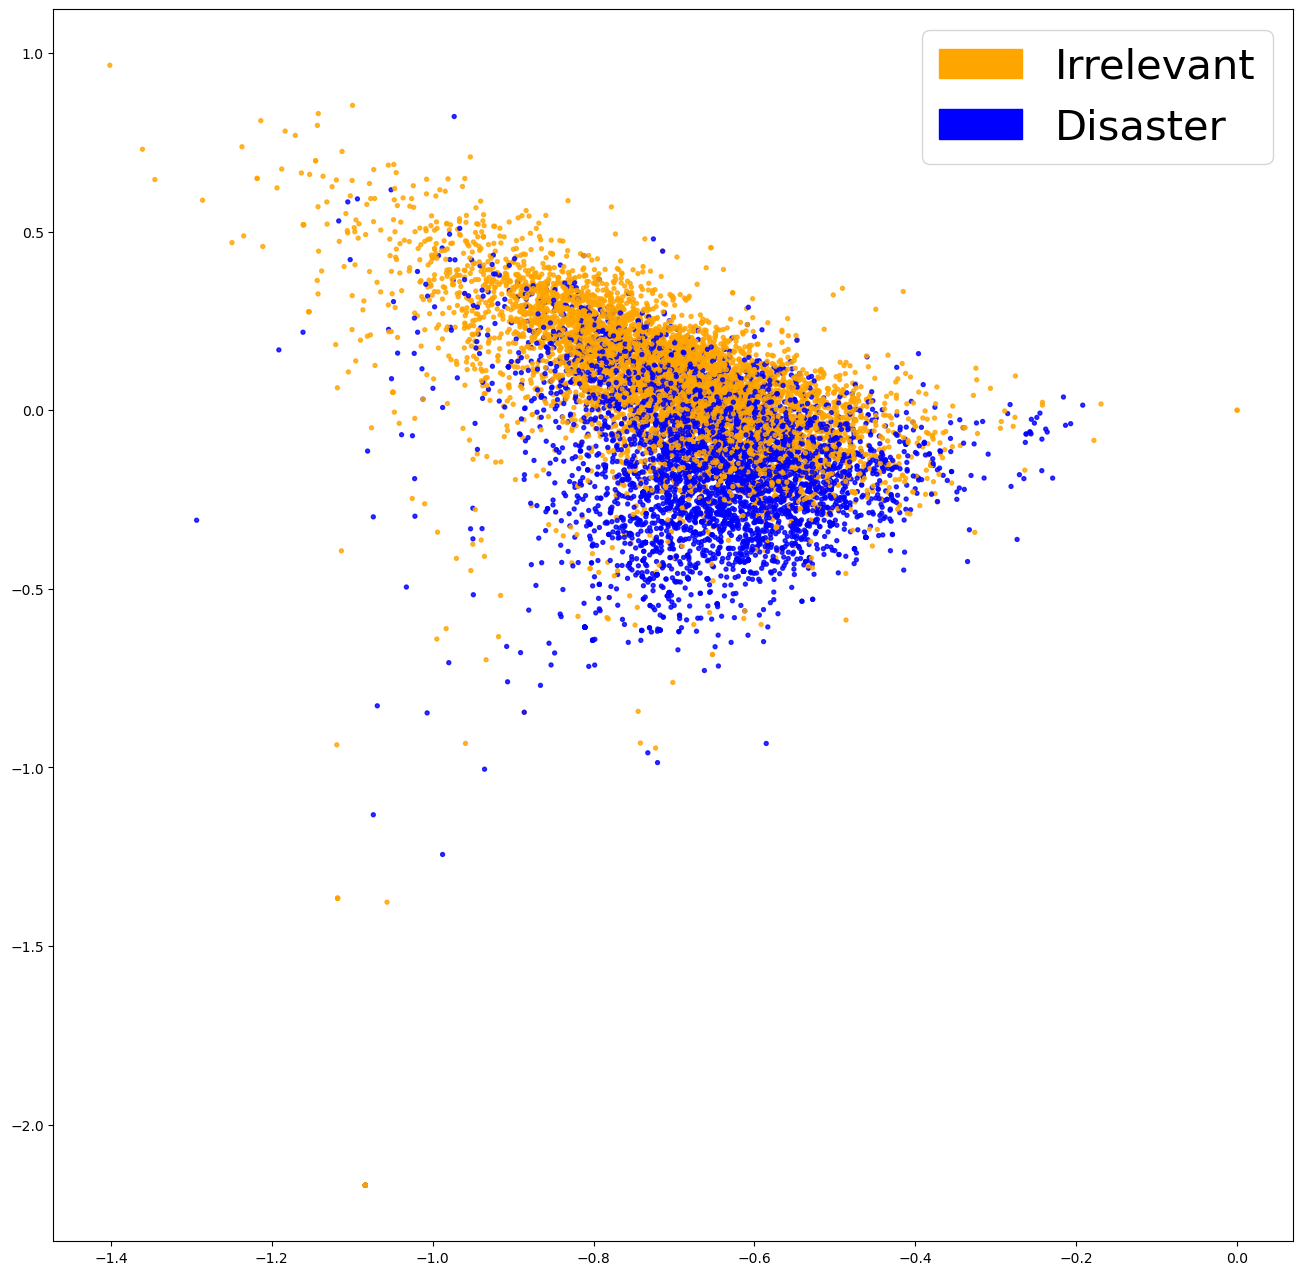

In [52]:
fig = plt.figure(figsize=(16, 16))
#plot_LSA(embeddings, list_labels)
plot_LSA(X_train_word2vec, y_train_word2vec)
plt.show()

In [49]:
#逻辑回归建模看结果
clf_word2vec = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40)
# 训练模型
clf_word2vec.fit(X_train_word2vec, y_train_word2vec)
# 使用训练好的逻辑回归模型clf对测试数据X_test_counts进行预测，得到预测结果y_predicted_counts。
y_predicted_word2vec = clf_word2vec.predict(X_test_word2vec)

In [53]:
#-评估
# 计算评估指标，传入 测试集的真实标签 和 预测标签
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
# 格式化输出评估指标，保留三位小数
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec))

accuracy = 0.777, precision = 0.776, recall = 0.777, f1 = 0.777


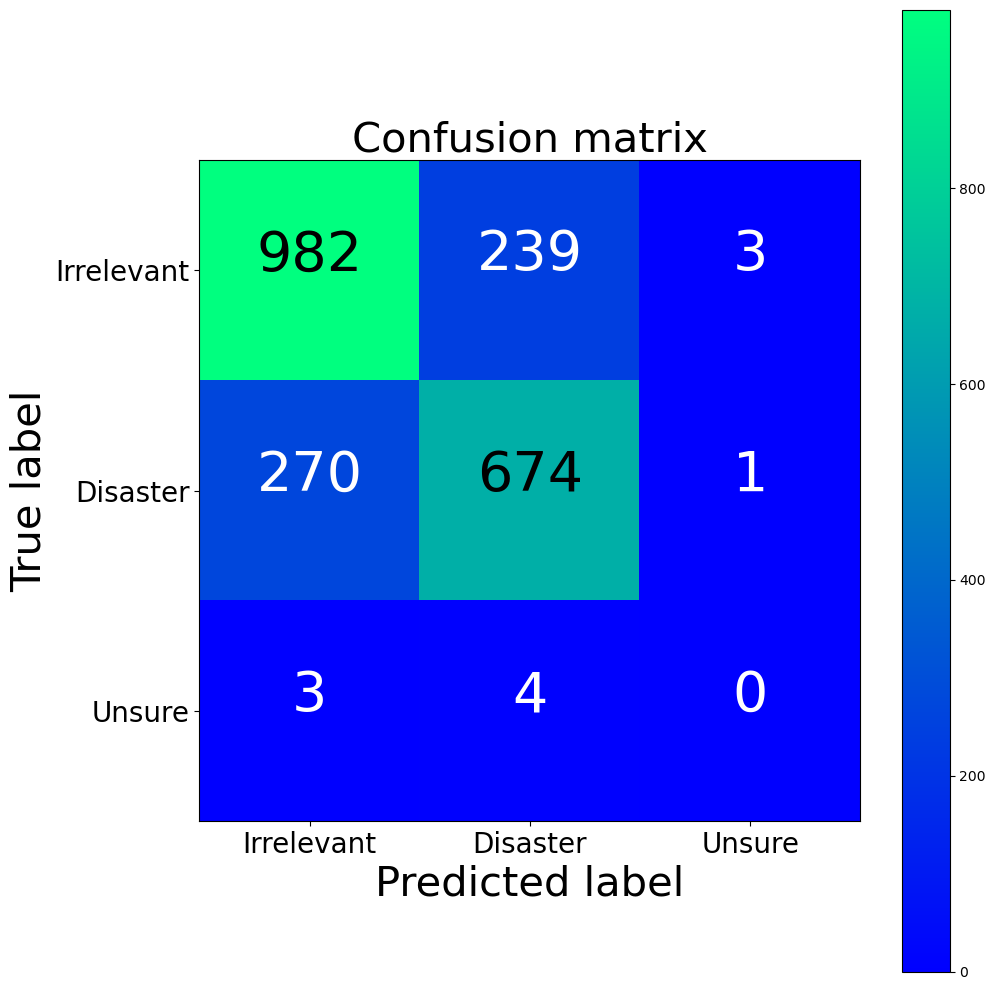

word2vec confusion matrix
[[980 242   2]
 [232 711   2]
 [  2   5   0]]
TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
词袋 confusion matrix
[[982 239   3]
 [270 674   1]
 [  3   4   0]]


In [54]:
#-混淆矩阵检查
cm_word2vec = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant', 'Disaster', 'Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("word2vec confusion matrix")
print(cm_word2vec)
print("TFIDF confusion matrix")
print(cm_tfidf)
print("词袋 confusion matrix")
print(cm)

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT =.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 19097 unique tokens.
(19098, 300)


In [61]:
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Model


def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    embedding_layer = Embedding(num_words,
                             embedding_dim,
                             weights=[embeddings],
                             input_length=max_sequence_length,
                             trainable=trainable)
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)


    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3, 4, 5]


    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)


    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)


    if extra_conv == True:
        x = Dropout(0.5)(l_merge)
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.5)(x)


    preds = Dense(labels_index, activation='softmax')(x)


    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [62]:
# 训练网络
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Epoch 1/3


2025-01-07 15:58:12.742225: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


68/68 [==============================] - 3s 38ms/step - loss: 0.5917 - acc: 0.7066 - val_loss: 0.4933 - val_acc: 0.7793
Epoch 2/3
68/68 [==============================] - 3s 37ms/step - loss: 0.4494 - acc: 0.8050 - val_loss: 0.4864 - val_acc: 0.7752
Epoch 3/3
68/68 [==============================] - 3s 37ms/step - loss: 0.3949 - acc: 0.8343 - val_loss: 0.4862 - val_acc: 0.7830
